## Nearest Neighbor item based Collaborative Filtering

In [0]:
import pandas as pd
import numpy as np

In [0]:
RC_df = pd.read_csv('/content/geoplaces2.csv',usecols=['placeID','name'],encoding='latin-1')
rating_df=pd.read_csv('/content/rating_final.csv',usecols=['userID', 'placeID', 'rating'],encoding='latin-1')

In [0]:
RC_df[['placeID','name']].head()

,placeID,name
0,134999,Kiku Cuernavaca
1,132825,puesto de tacos
2,135106,El Rincón de San Francisco
3,132667,little pizza Emilio Portes Gil
4,132613,carnitas_mata


In [0]:
rating_df[['userID', 'placeID', 'rating']].head()

,userID,placeID,rating
0,U1077,135085,6.900
1,U1077,135038,6.300
2,U1077,132825,7.600
3,U1077,135060,6.100
4,U1068,135104,5.900


In [0]:
df = pd.merge(rating_df,RC_df,on='placeID')
df.head()

,userID,placeID,rating,name
0,U1077,135085,6.900,Tortas Locas Hipocampo
1,U1108,135085,7.000,Tortas Locas Hipocampo
2,U1081,135085,6.200,Tortas Locas Hipocampo
3,U1056,135085,6.400,Tortas Locas Hipocampo
4,U1134,135085,5.500,Tortas Locas Hipocampo


In [0]:
combine_RC_rating = df.dropna(axis = 0, subset = ['name'])
RC_ratingCount = (combine_RC_rating.
     groupby(by = ['name'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'totalRatingCount'})
     [['name', 'totalRatingCount']]
    )
RC_ratingCount.head()


,name,totalRatingCount
0,Abondance Restaurante Bar,12
1,Arrachela Grill,3
2,Cabana Huasteca,13
3,Cafe Chaires,15
4,Cafeteria cenidet,6


In [0]:
rating_with_totalRatingCount = combine_RC_rating.merge(RC_ratingCount, left_on = 'name', right_on = 'name', how = 'left')
rating_with_totalRatingCount.head()

,userID,placeID,rating,name,totalRatingCount
0,U1077,135085,6.900,Tortas Locas Hipocampo,36
1,U1108,135085,7.000,Tortas Locas Hipocampo,36
2,U1081,135085,6.200,Tortas Locas Hipocampo,36
3,U1056,135085,6.400,Tortas Locas Hipocampo,36
4,U1134,135085,5.500,Tortas Locas Hipocampo,36


In [0]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(RC_ratingCount['totalRatingCount'].describe())

count   128.000
mean      9.000
std       6.152
min       3.000
25%       5.000
50%       7.000
75%      11.250
max      36.000
Name: totalRatingCount, dtype: float64


In [0]:
popularity_threshold = 15
rating_popular_RC= rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_RC.head()

,userID,placeID,rating,name,totalRatingCount
0,U1077,135085,6.900,Tortas Locas Hipocampo,36
1,U1108,135085,7.000,Tortas Locas Hipocampo,36
2,U1081,135085,6.200,Tortas Locas Hipocampo,36
3,U1056,135085,6.400,Tortas Locas Hipocampo,36
4,U1134,135085,5.500,Tortas Locas Hipocampo,36


In [0]:
rating_popular_RC.shape

(397, 5)

In [0]:
## First lets create a Pivot matrix
RC_features_df=rating_popular_RC.pivot_table(index='name',columns='userID',values='rating').fillna(0)
RC_features_df

userID,U1001,U1002,U1003,U1004,U1005,U1006,U1007,U1009,U1010,U1013,U1014,U1016,U1018,U1019,U1022,U1024,U1025,U1027,U1029,U1032,U1033,U1036,U1038,U1045,U1046,U1049,U1053,U1054,U1055,U1056,U1057,U1058,U1059,U1061,U1062,U1064,U1071,U1073,U1075,U1076,...,U1078,U1081,U1083,U1084,U1085,U1086,U1088,U1089,U1090,U1091,U1092,U1094,U1095,U1096,U1097,U1098,U1099,U1101,U1104,U1105,U1106,U1108,U1109,U1112,U1113,U1114,U1115,U1116,U1120,U1122,U1124,U1125,U1126,U1128,U1132,U1134,U1135,U1136,U1137,U1138
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Cafe Chaires,0.000,0.000,0.000,0.000,0.000,5.900,6.100,0.000,0.000,6.900,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,8.200,0.000,0.000,0.000,5.400,0.000,0.000,0.000,6.000,0.000,0.000,0.000,0.000,7.300,0.000,0.000,0.000,6.400,0.000,0.000,...,0.000,0.000,5.800,0.000,0.000,0.000,0.000,0.000,5.600,5.400,5.300,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,7.700,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,8.000,0.000,0.000,0.000,0.000
Cafeteria y Restaurant El Pacifico,0.000,0.000,0.000,5.900,6.500,0.000,6.000,0.000,0.000,0.000,0.000,5.800,6.500,0.000,6.700,6.300,0.000,0.000,0.000,6.800,0.000,0.000,0.000,5.800,0.000,6.300,6.200,6.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.200,0.000,6.700,0.000,...,0.000,4.200,0.000,0.000,0.000,0.000,5.800,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.700,0.000,7.600,5.900,0.000,6.700,5.100,6.100,0.000,7.000,0.000,0.000,0.000,6.400,0.000,5.400,5.200,0.000,0.000,7.300,0.000,6.300,0.000,0.000,0.000
El Herradero Restaurante and Bar,0.000,0.000,0.000,0.000,6.700,0.000,5.500,0.000,0.000,0.000,5.700,0.000,4.400,0.000,6.600,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,6.300,0.000,0.000,6.800,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,6.300,0.000,0.000,0.000,0.000,7.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,7.000,0.000,0.000,0.000,0.000,5.900,0.000,6.100,0.000,6.300,0.000,7.200,0.000,7.600,0.000,0.000,0.000,0.000,0.000,0.000,0.000
El Rincon de San Francisco,7.300,0.000,0.000,0.000,0.000,0.000,6.100,0.000,0.000,0.000,0.000,0.000,6.000,0.000,6.200,0.000,0.000,0.000,0.000,0.000,0.000,6.500,0.000,0.000,0.000,0.000,6.100,6.500,6.100,0.000,0.000,0.000,0.000,0.000,0.000,0.000,6.700,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,7.600,0.000,6.400,0.000,0.000,6.100,0.000,0.000,0.000,0.000,6.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.600,0.000,0.000,0.000,0.000,0.000,0.000,6.700,0.000,0.000,0.000,0.000,0.000
Gorditas Doa Gloria,0.000,0.000,0.000,0.000,0.000,0.000,0.000,6.600,0.000,0.000,0.000,6.600,0.000,7.200,0.000,6.200,0.000,0.000,5.300,5.800,0.000,6.300,0.000,5.900,0.000,0.000,0.000,0.000,0.000,0.000,5.800,0.000,0.000,7.000,5.800,0.000,5.600,6.100,5.900,0.000,...,4.700,0.000,0.000,0.000,0.000,0.000,0.000,6.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.900,0.000,4.300,0.000,5.800,0.000,0.000,6.000,0.000,6.300,0.000,6.900,0.000,5.300,0.000,0.000,0.000,0.000,0.000,0.000,5.700,0.000,6.700,0.000
Koye Sushi,0.000,0.000,5.300,0.000,0.000,6.100,0.000,6.700,6.000,6.300,0.000,0.000,0.000,6.600,0.000,0.000,0.000,0.000,0.000,6.600,0.000,6.600,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,6.300,0.000,0.000,0.000,0.000,0.000,0.000,6.000,4.400,0.000,0.000,0.000,0.000,6.400,0.000,0.000,7.200,6.700,0.000,0.000,0.000,0.000,6.000,0.000,0.000,0.000,6.500,0.000,4.100,0.000,0.000,0.000,0.000
La Cantina Restaurante,0.000,6.200,0.000,0.000,0.000,0.000,0.000,5.400,0.000,0.000,0.000,6.500,0.000,0.000,8.100,0.000,0.000,6.400,0.000,0.000,0.000,6.500,0.000,5.400,0.000,6.900,0.000,5.700,0.000,6.500,0.000,0.000,0.000,0.000,5.900,6.400,5.800,5.800,0.000,0.000,...,5.400,5.900,0.000,0.000,0.000,0.000,0.000,0.000,7.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,7.000,7.000

In [0]:
from scipy.sparse import csr_matrix

RC_features_df_matrix = csr_matrix(RC_features_df.values)

from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(RC_features_df_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [0]:
RC_features_df.shape

(19, 81)

In [0]:
query_index = int(input("Enter index of Restaurante (with base 0) from above list\n"))
print(query_index)
distances, indices = model_knn.kneighbors(RC_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 19)

Enter index of Restaurante (with base 0) from above list
3
3


In [0]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(RC_features_df.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, RC_features_df.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for El Rincon de San Francisco:

1: La Cantina Restaurante, with distance of 0.555918492355787:
2: Restaurante El Cielo Potosino, with distance of 0.5833218478059021:
3: Cafeteria y Restaurant El Pacifico, with distance of 0.6116852443079587:
4: puesto de tacos, with distance of 0.6365912211565308:
5: Tortas Locas Hipocampo, with distance of 0.6535120601301726:
6: Restaurant la Chalita, with distance of 0.6854458376264276:
7: Restaurante Marisco Sam, with distance of 0.7192141599630798:
8: Cafe Chaires, with distance of 0.7575935856832128:
9: La Virreina, with distance of 0.7928108061427668:
10: Gorditas Doa Gloria, with distance of 0.807062907263871:
11: Restaurant Oriental Express, with distance of 0.8275811938729547:
12: El Herradero Restaurante and Bar, with distance of 0.8378841185851791:
13: La Posada del Virrey, with distance of 0.8614282247759448:
14: Restaurante El Chivero S.A. de C.V., with distance of 0.8732201415197468:
15: Luna Cafe, with distance of 0.8898

In [0]:
l=[]
k=[]
for i in range(0, len(distances.flatten())):
    if i != 0:
        l.append(RC_features_df.index[indices.flatten()[i]]) 
        k.append(distances.flatten()[i])

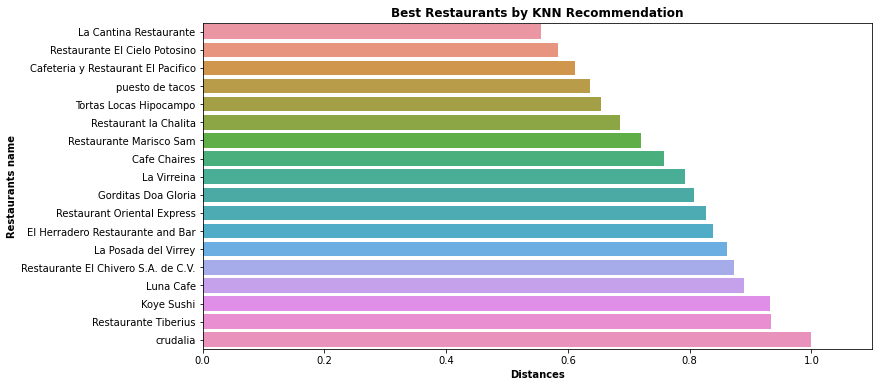

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,6))
ax=sns.barplot(x=k, y=l)
plt.xlim(0,1.1)
plt.title('Best Restaurants by KNN Recommendation', weight='bold')
plt.xlabel('Distances', weight='bold')
plt.ylabel('Restaurants name', weight='bold')
plt.savefig('KNN.png')